## 1. Declaring project variables

In the first cell we can choose a ticker, an interval, the number of days to train the model on, and the number of datapoints to look ahead to predict the future price. 

In this notebook I'll choose Quant price in USD Tether ('QNTUSDT') with a 4hour interval, and train our data on 720 days, prior to this month. 

The model will then predict the price for each datapoint from the beginning of the current month.

In [1]:
# Choose a currency and interval
ticker='QNTUSDT'
freq='4H'

# Choose the number of days to train the model on
train_days = 720

# Choose whether to look for a best regression model, or use a pre-saved one from a previous run, alternatively you can choose your own regression method.
init = 1                  # do not (0) or (1) calculate the best regressor
best_regressor = ''       # you can choose a regressor here

# Number of datapoints to lookahead
lookahead = 1             # predict the price for this datapoint

# Choose to see the best_regressor calculations in verbose mode
verbose = 0

# TSFresh rolling window size
max_window_size = 60      # max length of the rolled window for feature extraction
min_window_size = 5       # minimum number of days for a rolling window


## 2. Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import impute

from sklearn.utils import all_estimators
from sklearn import base
import sklearn.metrics as metrics 

from functions import init_regressors,load_data,get_best_regressor,view_performance

### Import all regressors from sklearn

This function will import all available sklearn regressors and write them into a .csv file. We currently can load a total of 203 available regression models.

In [3]:
if init==1:
    init_regressors(ticker)

Number of available regression models:  203


### 3. Import data

In this part we will load the data for {ticker} according to our {freq} from Binance.

First we need to define the current day of the month, to set the ranges for data to be loaded from the Binance API. 
We also need to set a range by getting the first and last day of the month for our plots to show nicely.

In [4]:
import calendar
from datetime import datetime   
from dateutil.relativedelta import relativedelta

today = datetime.now() 
# Define beginning of this month
beginning_of_month = datetime(today.year, today.month, 1, 0, 0, 0)
current_month = beginning_of_month.strftime('%Y-%m')

# Define the end of this month
last_day_of_month = datetime(today.year, today.month, calendar.monthrange(today.year, today.month)[1])

# Define this and last month for splitting train and test data
this_month = beginning_of_month.strftime('%Y-%m')
last_month = beginning_of_month - relativedelta(months=1)
last_month = last_month.strftime('%Y-%m')

# Number of lookback days to load data from the API
day_of_month = today.day 
total_days = train_days+day_of_month
lookback = str(total_days)+" days"     # use data for this period for training and test set

# Split the train and test data on these months
train_end = last_month     # train until the end of this month
test_start = this_month    # make predictions for this month

Here we load the data from the Binance API. We will only use the "close" price.


In [5]:
df=load_data(ticker,freq,lookback)

### Let's plot the timeseries

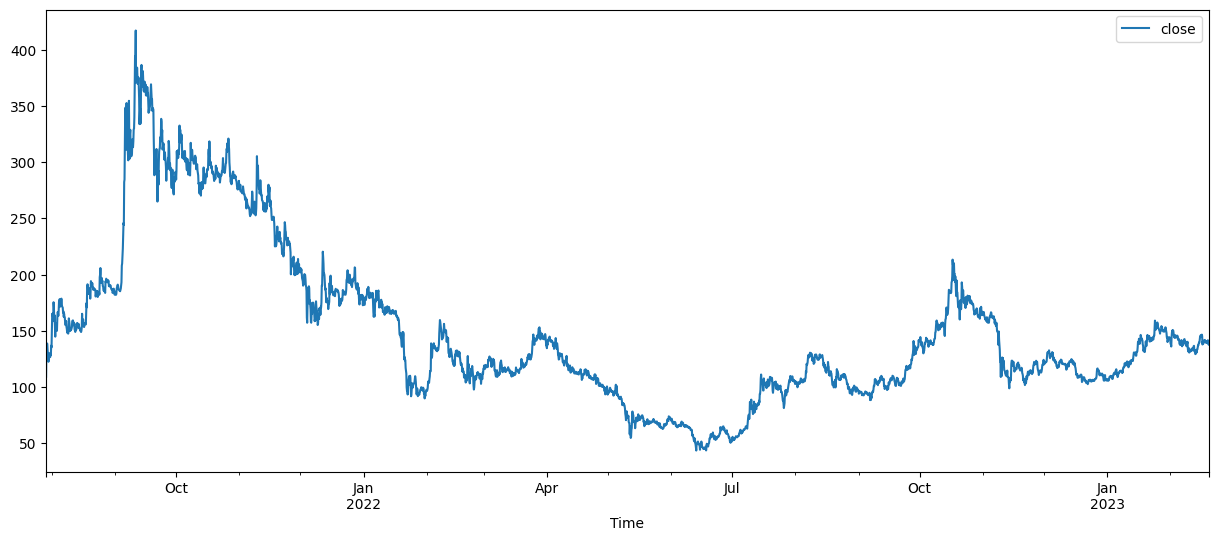

In [6]:
plt.figure(figsize=(15, 6))
df.plot(ax=plt.gca())
plt.show()

## 4. Tsfresh feature extraction

First we convert the loaded datafram into an indexed dataframe that tsfresh can work with. We display the last three timestamps in our timeseries.

In [7]:
df_melted = pd.DataFrame()
df_melted["timestamp"] = df.index
df_melted["close"] = df['close'].values
df_melted['Symbols'] = ticker
df_melted.tail(3)

,timestamp,close,Symbols
3422,2023-02-19 12:00:00,141.4,QNTUSDT
3423,2023-02-19 16:00:00,137.9,QNTUSDT
3424,2023-02-19 20:00:00,137.6,QNTUSDT


### Creating a rolling window

Here we create a rolling window of the timeseries as explained here. This creates our dataframe that will be used for feature extraction. The max_window will provide us with total_datapoints/max_window different rolling windows.

In [8]:
df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="timestamp",
                             max_timeshift=max_window_size, min_timeshift=min_window_size)

Rolling: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


### Feature extraction

We will extract features for each of these rolling windows, which are indexed with the "id" column. This creates our timeseries dataframe X, which has as many rows as there are rolling windows. The columns will represent all the extracted features that were calculated for each rolling window.

In [9]:
X = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="timestamp", column_value="close", 
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


### Indexing

We rename the index as the "last_timestamp", which identifies each rolling window by their last included datapoint. This will be important to connect the timestamps with their the target value.

In [10]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_timestamp"

### Create target

We need a target for the supervised learning. To create a target variable for any given datapoint, we simply have to shift the actual prices column by 1 datapoint. Now each timestamp will have a true price to train the model on.

In [11]:
y = df_melted.set_index("timestamp").sort_index().close.shift(-1)

**We should interpret this as follows**

The index represents the last timestamp from each rolling window. The value represents the price to be predicted from the previous timestamp, so the target for extracted features of the previous rolling window. 

Because the last timestamp has no real recorded value yet, this value will be NaN. We will remove this row to train the model.

In [12]:
y.tail(3)

timestamp
2023-02-19 12:00:00    137.9
2023-02-19 16:00:00    137.6
2023-02-19 20:00:00      NaN
Name: close, dtype: float64

### Equal data and target rows

Now there are (min_time_shift) datapoints in y that are not in y. 

This is because X is created feature extracted rows from the rolling windows (with lengths ranging from min_time_shift to max_window), and y is created from the loaded dataframe. 

This means that the windows will have been compressed into one row, with the smallest window minimum length of the smallest window, determined by (min_time_shift)
<br><br>
For this reason we remove the datapoints from the timeseries that are not in the target, so that both will have the same length.

In [13]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

### Define training and test data

Now that we have a valid timeseries (X) and their valid targets (y), we can start training. But first we need to define the size of the train and test data. 

Then we create a dataframe (X_train_selected) with the extracted features and targets for our training set. 

In [14]:
X_train = X[:train_end]
X_test = X[test_start:]

y_train = y[:train_end]
y_test = y[test_start:]

X_train_selected = select_features(X_train, y_train)

## 5. Select the best sklearn regression method

To speed up things we can first check if a best regressor was already chosen during a previous run by reading the value in the 'regressor_min_mae{ticker}.csv' file. 

In [15]:
try:
    with open(f'regressor_min_mae_{ticker}.csv') as f:
        best_regressor=f.read()
    print ('Last saved regression method:',best_regressor)
except:
    pass

### Calculate the best regressor 
If a best regressor is not available or init==1 in the variables declaration, a new best regressor will be calculated. The regressor with the lowest mean absolute error (MAE) will be selected.

With the function get_best_regressor() we run over all the sklearn regression models and evaluate their metrics. The result will be printed as a dataframe where we can see the five best regression methods for this training data.



In [16]:
# For cleaner output we suppress warnings that occur during testing of the estimators
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=FutureWarning)
simplefilter("ignore", category=RuntimeWarning)
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UserWarning)

# Check and proceed if init=1 or no best_regressor was found
if (best_regressor =='') | init==1:

    # Create a list for regressors with too bad performance
    new_removed_regressors=[]
    removed_regressors=pd.DataFrame()

    # Calculate all the estimator metrics
    MAE,MSE,RMSE,R2,removed_regressors,new_removed_regressors=get_best_regressor(X_train_selected,X_test,y_train,y,test_start,ticker,verbose)

    # Write the results to this file
    with open(f'regressor_min_mae_{ticker}.csv','w') as f:
        f.write(min(MAE, key=MAE.get))

    # Define the best estimator by chosing the one with the smallest MAE
    best_regressor=min(MAE, key=MAE.get)

    # Create a dataframe with the excluded estimators and write it to a file, so we can exclude them in future runs 
    if new_removed_regressors!='None':
        new_removed_regressors=pd.DataFrame(new_removed_regressors,columns=['name'])
        removed_regressors=pd.concat([removed_regressors,new_removed_regressors])
        removed_regressors.to_csv(f'removed_regressors_{ticker}.csv','a',index=False)

# Load the estimator model and store its name
estimators=all_estimators()
for est_name, estimator in estimators:    
    if str(best_regressor)==est_name:
        best_regressor=estimator()
        name=est_name

# Print out the five best estimators
df_best_regressors=pd.DataFrame.from_dict({'MAE': MAE, 'RMSE' : RMSE, 'R2_score': R2})
df_best_regressors = df_best_regressors.sort_values(by="MAE",ascending=True).head().reset_index() 
df_styled=df_best_regressors.style.apply(lambda x: ['background-color: lightgreen' if x.name == 0 else '' for i in x], axis=1)

display(df_styled)

Number of available regression models:  203
 >>> REMOVING  GaussianProcessRegressor
 >>> REMOVING  Lars
 >>> REMOVING  LinearSVR
 >>> REMOVING  MLPRegressor
 >>> REMOVING  RidgeCV
 >>> REMOVING  SGDRegressor


,index,MAE,RMSE,R2_score
0,ARDRegression,1.635256,2.136844,0.817325
1,ElasticNet,1.704834,2.278418,0.792317
2,Lasso,1.710826,2.273030,0.793298
3,BayesianRidge,1.766118,2.317229,0.785182
4,LassoLarsIC,1.791235,2.309802,0.786557


## 6. Train the model with the best regression method

We train our model on the training dataset using our newly found best regressor. Then we use this model to predict the prices on the training data set.

In [17]:
# Train the estimator on the training set
best_regressor.fit(X_train_selected, y_train)

# Prepare the test data
X_test_selected = X_test[X_train_selected.columns]

# Predict values on the test data
y_pred = pd.Series(best_regressor.predict(X_test_selected), index=X_test_selected.index)

We can see that the actual price for the last timestamp is still the target in the previous timestamp in our test data.

In [18]:
y.tail(3)

timestamp
2023-02-19 12:00:00    137.9
2023-02-19 16:00:00    137.6
2023-02-19 20:00:00      NaN
Name: close, dtype: float64

When we check the predicted values, we can see that the model has predicted a value for the last timestamp, meaning that it predicts that this will be the real value (or "close price') for the next upcoming timestamp.

In [19]:
y_pred.tail(3)

last_timestamp
2023-02-19 12:00:00    141.338080
2023-02-19 16:00:00    139.193664
2023-02-19 20:00:00    138.809326
dtype: float64

## 7. Plot the predictions

Now that we have trained our model and unleashed it on the test data, we can see the predictions. The following graphs plot the actual price in blue, versus the predicted price, in orange.  

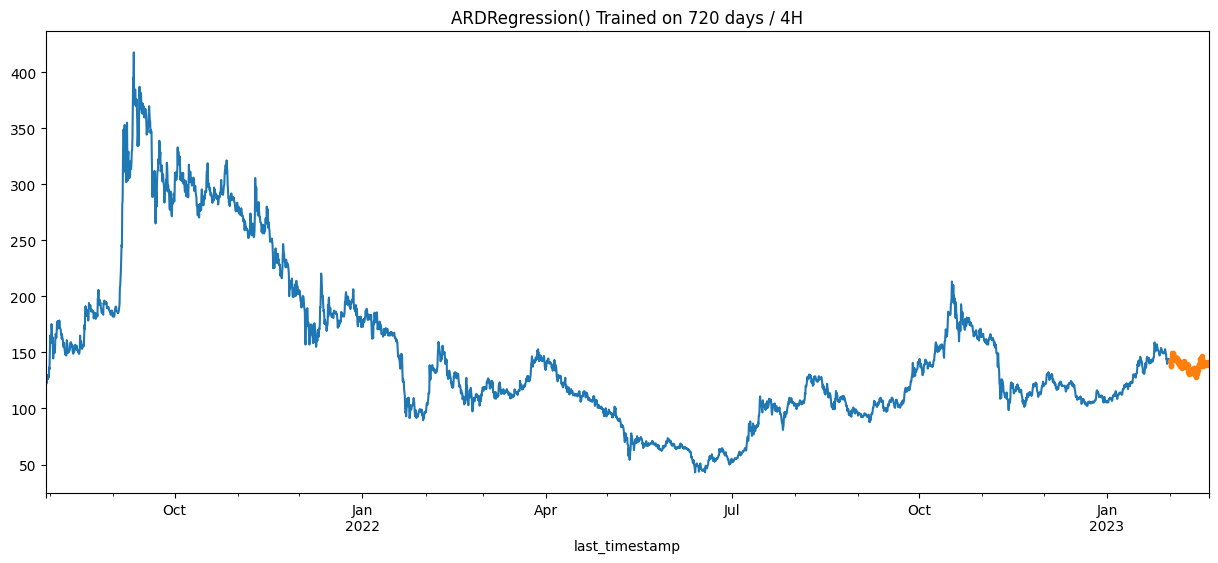

In [20]:
plt.figure(figsize=(15, 6)) 
y.plot()
y_pred.plot(legend=None, marker=".", title=(str(best_regressor)+' Trained on '+str(train_days)+' days / ' + str(freq)))

plt.savefig(f'{ticker}_{name}_{train_days}_days_training.png')

### Plot the predictions for current month
In this graph we zoom in to only see the price predictions for the current month.

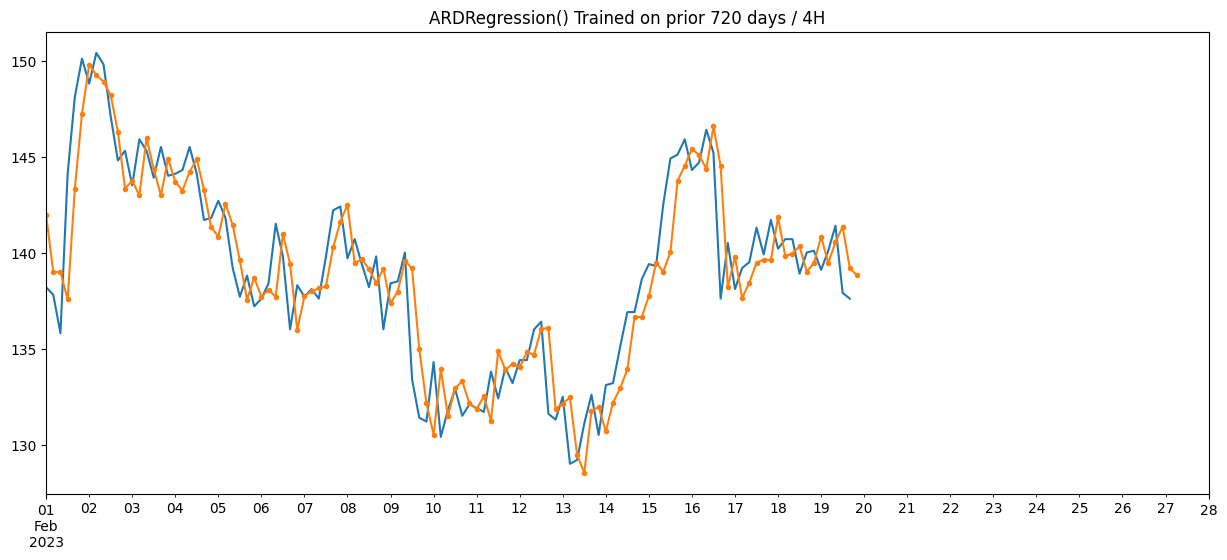

In [21]:
# Plot the last part of the graph
start_date = beginning_of_month
end_date = last_day_of_month

# Create a DatetimeIndex with the range for this month
index = pd.date_range(start=start_date, end=end_date, freq=freq)
real_values = y.reindex(index)
predicted_values = y_pred.reindex(index)

# Plot the graph
plt.figure(figsize=(15, 6))
real_values.plot()
predicted_values.plot( legend=None, marker=".", title=(str(best_regressor)+' Trained on prior '+str(train_days)+' days / ' + str(freq)))

plt.savefig(f'{ticker}_{name}_{train_days}_{current_month}_days_training.png')

## 8. View the performance

We will print out a graph to see the differences between predicted price and actual prices.

For this we will build a *test_results* dataframe which contains the actual price and the price prediction. 

In [22]:
test_results=pd.concat([y_test,y_pred],axis=1)
test_results.columns=['close','prediction']

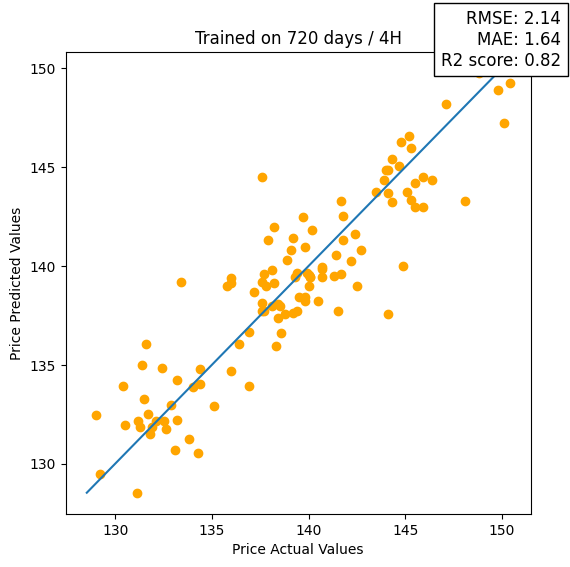

In [23]:
view_performance(test_results, train_days, freq)

## 9. Compare predictions with truth values

Now we want to compare the predictions with the actual value and show the predicted price for the next datapoint in our timeseries!

For that we make a new dataframe, called *df_predictions*, which holds the values of *y_pred*.

**Remember:** *y_pred* holds the predicted values for the NEXT datapoints, so we will have to make some changes on *df_prediction* to produce a good prediction table!

In [24]:
df_predictions=pd.DataFrame( y_pred ,columns=['predicted_close']) 
df_predictions.tail(3)

,predicted_close
last_timestamp,
2023-02-19 12:00:00,141.338080
2023-02-19 16:00:00,139.193664
2023-02-19 20:00:00,138.809326


First we create a dataframe with the prediction values, then we will merge it with *df_time*, a new dataframe that will have as much future datapoints as our *lookahead* variable.

In [25]:
# Create a calendar
# Set the start date and number of periods

num_periods = lookahead + 1

now = datetime.now()
remainder = now.hour % 4
start_date = datetime(now.year, now.month, now.day, now.hour - remainder, 0, 0)

# Convert the start date to a Timestamp object
start_date = pd.Timestamp(start_date)

# Set the time part of the start date to 00:00:00
#start_date = start_date.normalize()
df_time=pd.date_range(start = start_date, periods = num_periods,freq=freq).to_frame()
df_time.tail()
  
df_time.columns = ['timestamp'] 
df_time["timestamp"] = df_time["timestamp"].apply(lambda x: x.strftime("%Y-%m-%d %H:00:00"))

df_time['timestamp']= pd.to_datetime(df_time['timestamp'])
#df_time['predicted_close']=df_predictions['close']
df_time

,timestamp
2023-02-19 20:00:00,2023-02-19 20:00:00
2023-02-20 00:00:00,2023-02-20 00:00:00


We now add a timestamp column to *df_time* so we can merge this table with *df_prediction*.

In [26]:
df_predictions['timestamp']=df_predictions.index  

#Add new dates from df_time so we can move the pred_close to the next date

df_predictions=pd.merge(df_predictions,df_time,on='timestamp', how="outer")
df_predictions.tail(3)


,predicted_close,timestamp
112,139.193664,2023-02-19 16:00:00
113,138.809326,2023-02-19 20:00:00
114,NaN,2023-02-20 00:00:00


Now we need to shift the *predicted_close* column as much datapoints as our *lookahead* variable. 

In [27]:
df_predictions['predicted_close'] = df_predictions['predicted_close'].sort_index().shift(lookahead)
df_predictions.tail(3)

,predicted_close,timestamp
112,141.338080,2023-02-19 16:00:00
113,139.193664,2023-02-19 20:00:00
114,138.809326,2023-02-20 00:00:00


We now construct a new dataframe with the actual real close prices, and merge it with the predicted values.

In [28]:
df_real_values=df_melted[['timestamp','close']]
df_real_values.reset_index(drop=True,inplace=True)
df_real_values['real_close']=df_real_values.close
df_real_values.drop('close',axis=1,inplace=True) 

df_future=pd.merge(df_real_values,df_predictions, on='timestamp', how='outer' )
df_future.tail(8) 

,timestamp,real_close,predicted_close
3418,2023-02-18 20:00:00,140.0,139.003962
3419,2023-02-19 00:00:00,140.1,139.452822
3420,2023-02-19 04:00:00,139.1,140.828951
3421,2023-02-19 08:00:00,140.1,139.447627
3422,2023-02-19 12:00:00,141.4,140.545271
3423,2023-02-19 16:00:00,137.9,141.338080
3424,2023-02-19 20:00:00,137.6,139.193664
3425,2023-02-20 00:00:00,NaN,138.809326


So to conclude we have a predicted price for our next datapoint and hopefully it will match with the real_close price!
